In [1]:
import pandas as pd
import numpy as np
import librosa
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
audio_file_dir = "Data/genres_original"
dataset = "Data/features_30_sec.csv"

In [3]:
metadata = pd.read_csv(dataset)
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mffcs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mffcs_scaled_features

In [5]:
extracted_features = []
for index, row in tqdm(metadata.iterrows()):
    try:
        current_label = row["label"]
        file_name = os.path.join(os.path.abspath(audio_file_dir), current_label+'\\', str(row["filename"]))
        data = features_extractor(file_name)
        extracted_features.append([data, current_label])
    except Exception as e:
        print(f"Error : {e}")
        continue

554it [02:23,  6.04it/s]C:\Users\EthiK\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
556it [02:23,  5.18it/s]

Error : 


1000it [04:07,  4.03it/s]


In [6]:
extracted_features_dataFrame = pd.DataFrame(extracted_features, columns=["feature", "class"])
extracted_features_dataFrame["class"].value_counts()

reggae       100
pop          100
metal        100
rock         100
blues        100
disco        100
country      100
hiphop       100
classical    100
jazz          99
Name: class, dtype: int64

In [7]:
x = np.array(extracted_features_dataFrame["feature"].tolist())
y = np.array(extracted_features_dataFrame["class"].tolist())

x.shape

(999, 40)

In [8]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

y.shape

(999, 10)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(799, 40)
(200, 40)
(799, 10)
(200, 10)


In [10]:
model = Sequential()
model.add(Dense(1024, input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(y.shape[1], activation="softmax"))

#model.summary()

In [11]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
num_epochs = 100
num_batch_size = 32
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=num_batch_size, validation_data=(x_test, y_test), verbose=0)

In [12]:
model.evaluate(x_test, y_test, verbose=0)

[1.673704981803894, 0.6299999952316284]

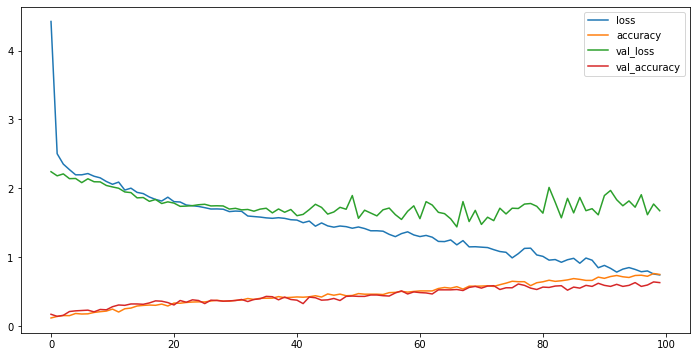

In [13]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [14]:
'''model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5')'''

"model_json = model.to_json()\nwith open('model.json', 'w') as json_file:\n    json_file.write(model_json)\nmodel.save_weights('model.h5')"

In [16]:
fileName = "../Test_Genres/rock.00000.wav"
scaled_feature = features_extractor(fileName)
scaled_feature = scaled_feature.reshape(1, -1)
predict_x=model.predict(scaled_feature) 
classes_x=np.argmax(predict_x,axis=1)

prediction_class = labelencoder.inverse_transform(classes_x)
print(classes_x)
print(prediction_class)


[9]
['rock']
